# Image Classification

#### Author: Gan Tu
In this project, I'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. I'll preprocess the images, then train a convolutional neural network on all the samples. I first normalize the images and one-hot encode the labels. Then, I build a network with convolutional, max pooling, dropout, and fully connected layers. 
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [70]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Feel free to play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


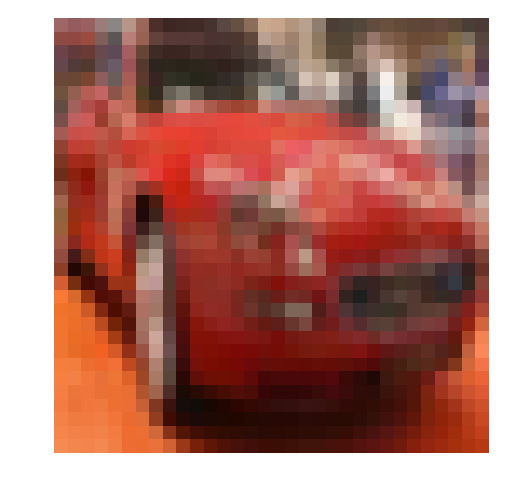

In [71]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, the `normalize` function takes in image data, `x`, and return it as a normalized Numpy array. The values are in the range of 0 to 1, inclusive.  The return object is the same shape as `x`.

In [73]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return x / 255


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
This is preprocessing function `one_hot_encode`. The input, `x`, are a list of labels.  The function returns the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function returns the same encoding for each value between each call to `one_hot_encode`.

In [74]:
# Mapping of encodings
encoding_map = dict()
for i in range(10):
    encoding_map[i] = np.zeros(10)
    encoding_map[i][i] = 1
    
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    labels = list()
    for label in x:
        labels.append(encoding_map[label])
    return np.array(labels)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
The order of the samples are randomized already, but it doesn't hurt to randomize it again if you want.

## Preprocess all the data and save it
The code cell below preprocesses all the CIFAR-10 data and save it to file. 
The code below also uses 10% of the training data for validation.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, I'll build each layer into a function.  

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. 

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [2]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None, *image_shape), name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=[None, n_classes], name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
The function `conv2d_maxpool` applies convolution then max pooling:

**Note:** I **won't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer but TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. I'll use the shortcut option for all the **other** layers.

In [3]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    batch_size, input_height, input_width, input_depth = x_tensor.shape
    W = tf.Variable(tf.truncated_normal([*conv_ksize, int(input_depth), conv_num_outputs], stddev=1/tf.sqrt(float(conv_num_outputs)), dtype=tf.float32))
    b = tf.Variable(tf.zeros([conv_num_outputs], tf.float32))
    x = tf.nn.conv2d(x_tensor, W, strides=[1, *conv_strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, *pool_ksize, 1], strides=[1, *pool_strides, 1], padding='SAME')
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
The `flatten` function changes the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  
The output should be the shape (*Batch Size*, *Flattened Image Size*).

In [4]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    batch_size, h, w, d = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, shape=[-1, h * w *d])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
The `fully_conn` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [5]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=tf.nn.relu)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
The `output` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*).

In [6]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Use Linear Activation Function
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs, activation_fn=None)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
The function `conv_net` creates a convolutional neural network model. 

The function takes in a batch of images, `x`, and outputs logits.

In [7]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    x = conv2d_maxpool(x, 16, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 32, (5, 5), (1, 1), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 64, (5, 5), (1, 1), (2, 2), (2, 2))
    x = tf.nn.dropout(x, keep_prob)
    x = flatten(x)
    x = fully_conn(x, 256)
    x = tf.nn.dropout(x, keep_prob)
    x = fully_conn(x, 64)
    x = tf.nn.dropout(x, keep_prob)
    x = output(x, 10)
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
The function `train_neural_network` does a single optimization. 

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [8]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
The function `print_stats` prints loss and validation accuracy.  

I use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  

Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [9]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print("Loss: {0:.5f}; Validation Accuracy: {1:.5f}".format(loss, accuracy))

### Hyperparameters
Tune the following parameters:
* `epochs`: the number of iterations until the network stops learning or start overfitting
* `batch_size`: the highest number that your machine has memory for.  
* `keep_probability`: the probability of keeping a node using dropout

In [128]:
epochs = 45
batch_size = 128
keep_probability = 0.55

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while we iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.31374; Validation Accuracy: 0.12680
Epoch  2, CIFAR-10 Batch 1:  Loss: 2.26729; Validation Accuracy: 0.16420
Epoch  3, CIFAR-10 Batch 1:  Loss: 2.17727; Validation Accuracy: 0.25200
Epoch  4, CIFAR-10 Batch 1:  Loss: 2.16242; Validation Accuracy: 0.29360
Epoch  5, CIFAR-10 Batch 1:  Loss: 2.08108; Validation Accuracy: 0.34160
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.97501; Validation Accuracy: 0.34420
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.92793; Validation Accuracy: 0.38540
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.89503; Validation Accuracy: 0.37200
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.81047; Validation Accuracy: 0.41680
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.70823; Validation Accuracy: 0.42340
Epoch 11, CIFAR-10 Batch 1:  Loss: 1.65075; Validation Accuracy: 0.42540
Epoch 12, CIFAR-10 Batch 1:  Loss: 1.58465; Validation Accuracy: 0.44780
Epoch 13, CIFAR-10 Batch 1:  Loss: 1.52984; Validation Accuracy: 0.45700
Epoch 14

### Fully Train the Model
Now that we got a fair accuracy with a single CIFAR-10 batch, try it with all five batches.

In [130]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.29066; Validation Accuracy: 0.15920
Epoch  1, CIFAR-10 Batch 2:  Loss: 2.15733; Validation Accuracy: 0.22720
Epoch  1, CIFAR-10 Batch 3:  Loss: 2.00855; Validation Accuracy: 0.29060
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.93108; Validation Accuracy: 0.34260
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.86021; Validation Accuracy: 0.37160
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.92380; Validation Accuracy: 0.36860
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.74541; Validation Accuracy: 0.41280
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.50653; Validation Accuracy: 0.41220
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.63966; Validation Accuracy: 0.42340
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.65433; Validation Accuracy: 0.44200
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.77884; Validation Accuracy: 0.45640
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.55757; Validation Accuracy: 0.45840
Epoch  3, CIFAR-10 Batch 3:  Loss: 1.30005; Validation Accuracy: 0.46100
Epoch  3, CIFAR-10 Batch 4:  Loss: 1.49

# Checkpoint
The model has been saved to disk.
## Test Model
Test the model against the test dataset.  This will be our final accuracy.

Testing Accuracy: 0.6954113924050633



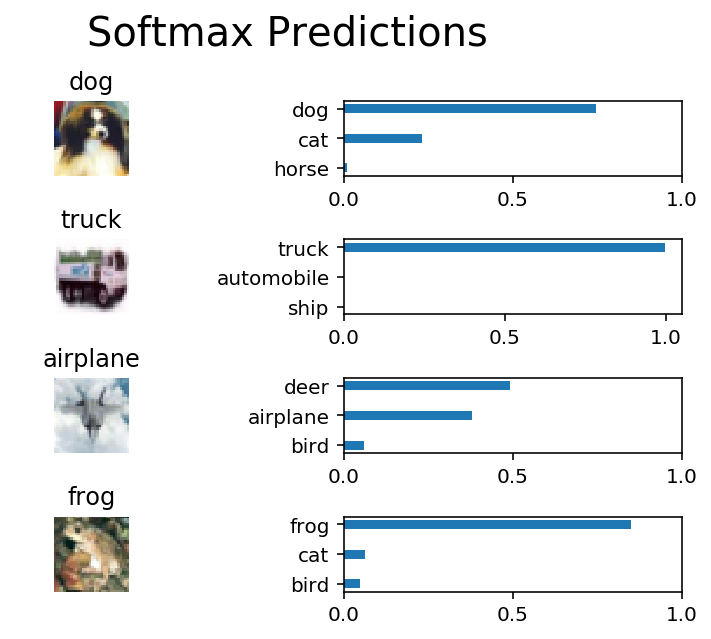

In [132]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why I can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get us 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because I haven't learned all there is about neural networks. I will update the net after I learned more techniques